# Kweather 데이터에 대한 관찰 코드

https://www.kaggle.com/izzettunc/introduction-to-time-series-clustering

## 1. Parameter Setting

In [1]:
import sys
sys.path.append("../")
sys.path.append("../..")

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(14, 4)

# 1.Data ingestion parameter
import pandas as pd
from datetime import timedelta
duration_day = 1 # 1 or 7
start_time = pd.to_datetime("2021-02-25 00:00:00")
end_time = start_time + timedelta(days = duration_day)
duration = {'start_time':start_time, 'end_time':end_time}
db_name = 'farm_strawberry_open'
feature_list = ['groundTemperature']# ['in_noise','in_pm01', 'in_pm01_raw', 'in_pm10', 'in_pm10_raw', 'in_pm25','in_pm25_raw', 'in_temp', 'voc']
feature_name = feature_list[0]


fig_width_num = 4
fig_width = 30
fig_height = 30


# 2.Data manipulation parameter
freq_min = 60
import datetime
timedelta_frequency_sec = datetime.timedelta(minutes= freq_min)
# 3. Nan Processing Parameter
# 3-1. NanLImitProcessingInfo = {'type':'ratio', 'ConsecutiveNanLimit':0.05, 'totalNaNLimit':1} # seconds
# 3-2. NanLImitProcessingInfo = {'type':'time', 'ConsecutiveNanLimit':1*60*60, 'totalNaNLimit':5*60*60} #seconds
# 3-3.
NanInfoForClenData = {'type':'num', 'ConsecutiveNanLimit':1, 'totalNaNLimit':3}

## 1. dataset Prepration

In [2]:
from clust.ingestion.influx import influx_Client_v2 as influx_Client, multipleDataSets
from setting import influx_setting_KETI as ins
db_client = influx_Client.influxClient(ins.CLUSTDataServer2)
dataSet = multipleDataSets.get_all_msdata_in_bucket(start_time, end_time, db_client, db_name)

/home/jwmoon/.local/lib/python3.8/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    import "influxdata/influxdb/schema" schema.measurements(bucket: "farm_strawberry_open") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    warnings.simplefilter("ignore", MissingPivotFunction)

For more info see:
    - https://docs.influxdata.com/resources/videos/pivots-in-flux/
    - https://docs.influxdata.com/flux/latest/stdlib/universe/pivot/
    - https://docs.influxdata.com/flux/latest/stdlib/influxdata/influxdb/schema/fieldsascols/

  warnings.warn(message, MissingPivotFunction)


## 2. preprocessing (refinement, error handling)

In [3]:
# dataSet 형태기 때문에 dataSet형태의 전처리가 필요함

from Clust.clust.ingestion.mongo import customModules
from Clust.clust.ingestion.mongo import mongo_Client
#db에서 가져온 데이터로 만든 민맥스
mongo_client = mongo_Client.mongoClient(ins.CLUSTMetaInfo2)
min_max_from_db = customModules.get_min_max_info_from_bucketMeta(mongo_client, db_name)
print(min_max_from_db)
#필수적인 오류 데이터에 대해서 NaN 처리함
from clust.preprocessing.dataPreprocessing import DataProcessing
CertainParam= {'flag': True, 'data_min_max_limit':min_max_from_db}
refine_param = {'removeDuplication': {'flag': True}, 'staticFrequency': {'flag': True, 'frequency': timedelta_frequency_sec}}
outlier_param ={
    "certainErrorToNaN":CertainParam, 
    "unCertainErrorToNaN":{'flag': False}
}
imputation_param = {"flag":False}
process_param = {'refine_param':refine_param, 'outlier_param':outlier_param, 'imputation_param':imputation_param}

partialP = DataProcessing(process_param)
multiple_dataset = partialP.multiDataset_all_preprocessing(dataSet)

{'max_num': {}, 'min_num': {}}


## 3. get one dataframe 

In [4]:
from Clust.clust.transformation.general import dataframe
dataDF = dataframe.get_oneDF_with_oneFeature_from_multipleDF(multiple_dataset, feature_name, duration, timedelta_frequency_sec)

## 4. remove bad column

In [5]:
from Clust.clust.quality.NaN import cleanData
CMS = cleanData.CleanData()
data = CMS.get_cleanData_by_removing_column(dataDF, NanInfoForClenData) 

In [6]:
print(len(dataDF.columns))
print(len(data.columns))

47
23


## 5. Clustering

### 5-1. Preprocessing for clustering

In [7]:
from Clust.clust.ML.clustering import interface, preprocessing
from Clust.clust.ML.clustering.somClustering import SomClustering
data = preprocessing.processing_for_clustering(data, ewm_parameter=0.9)

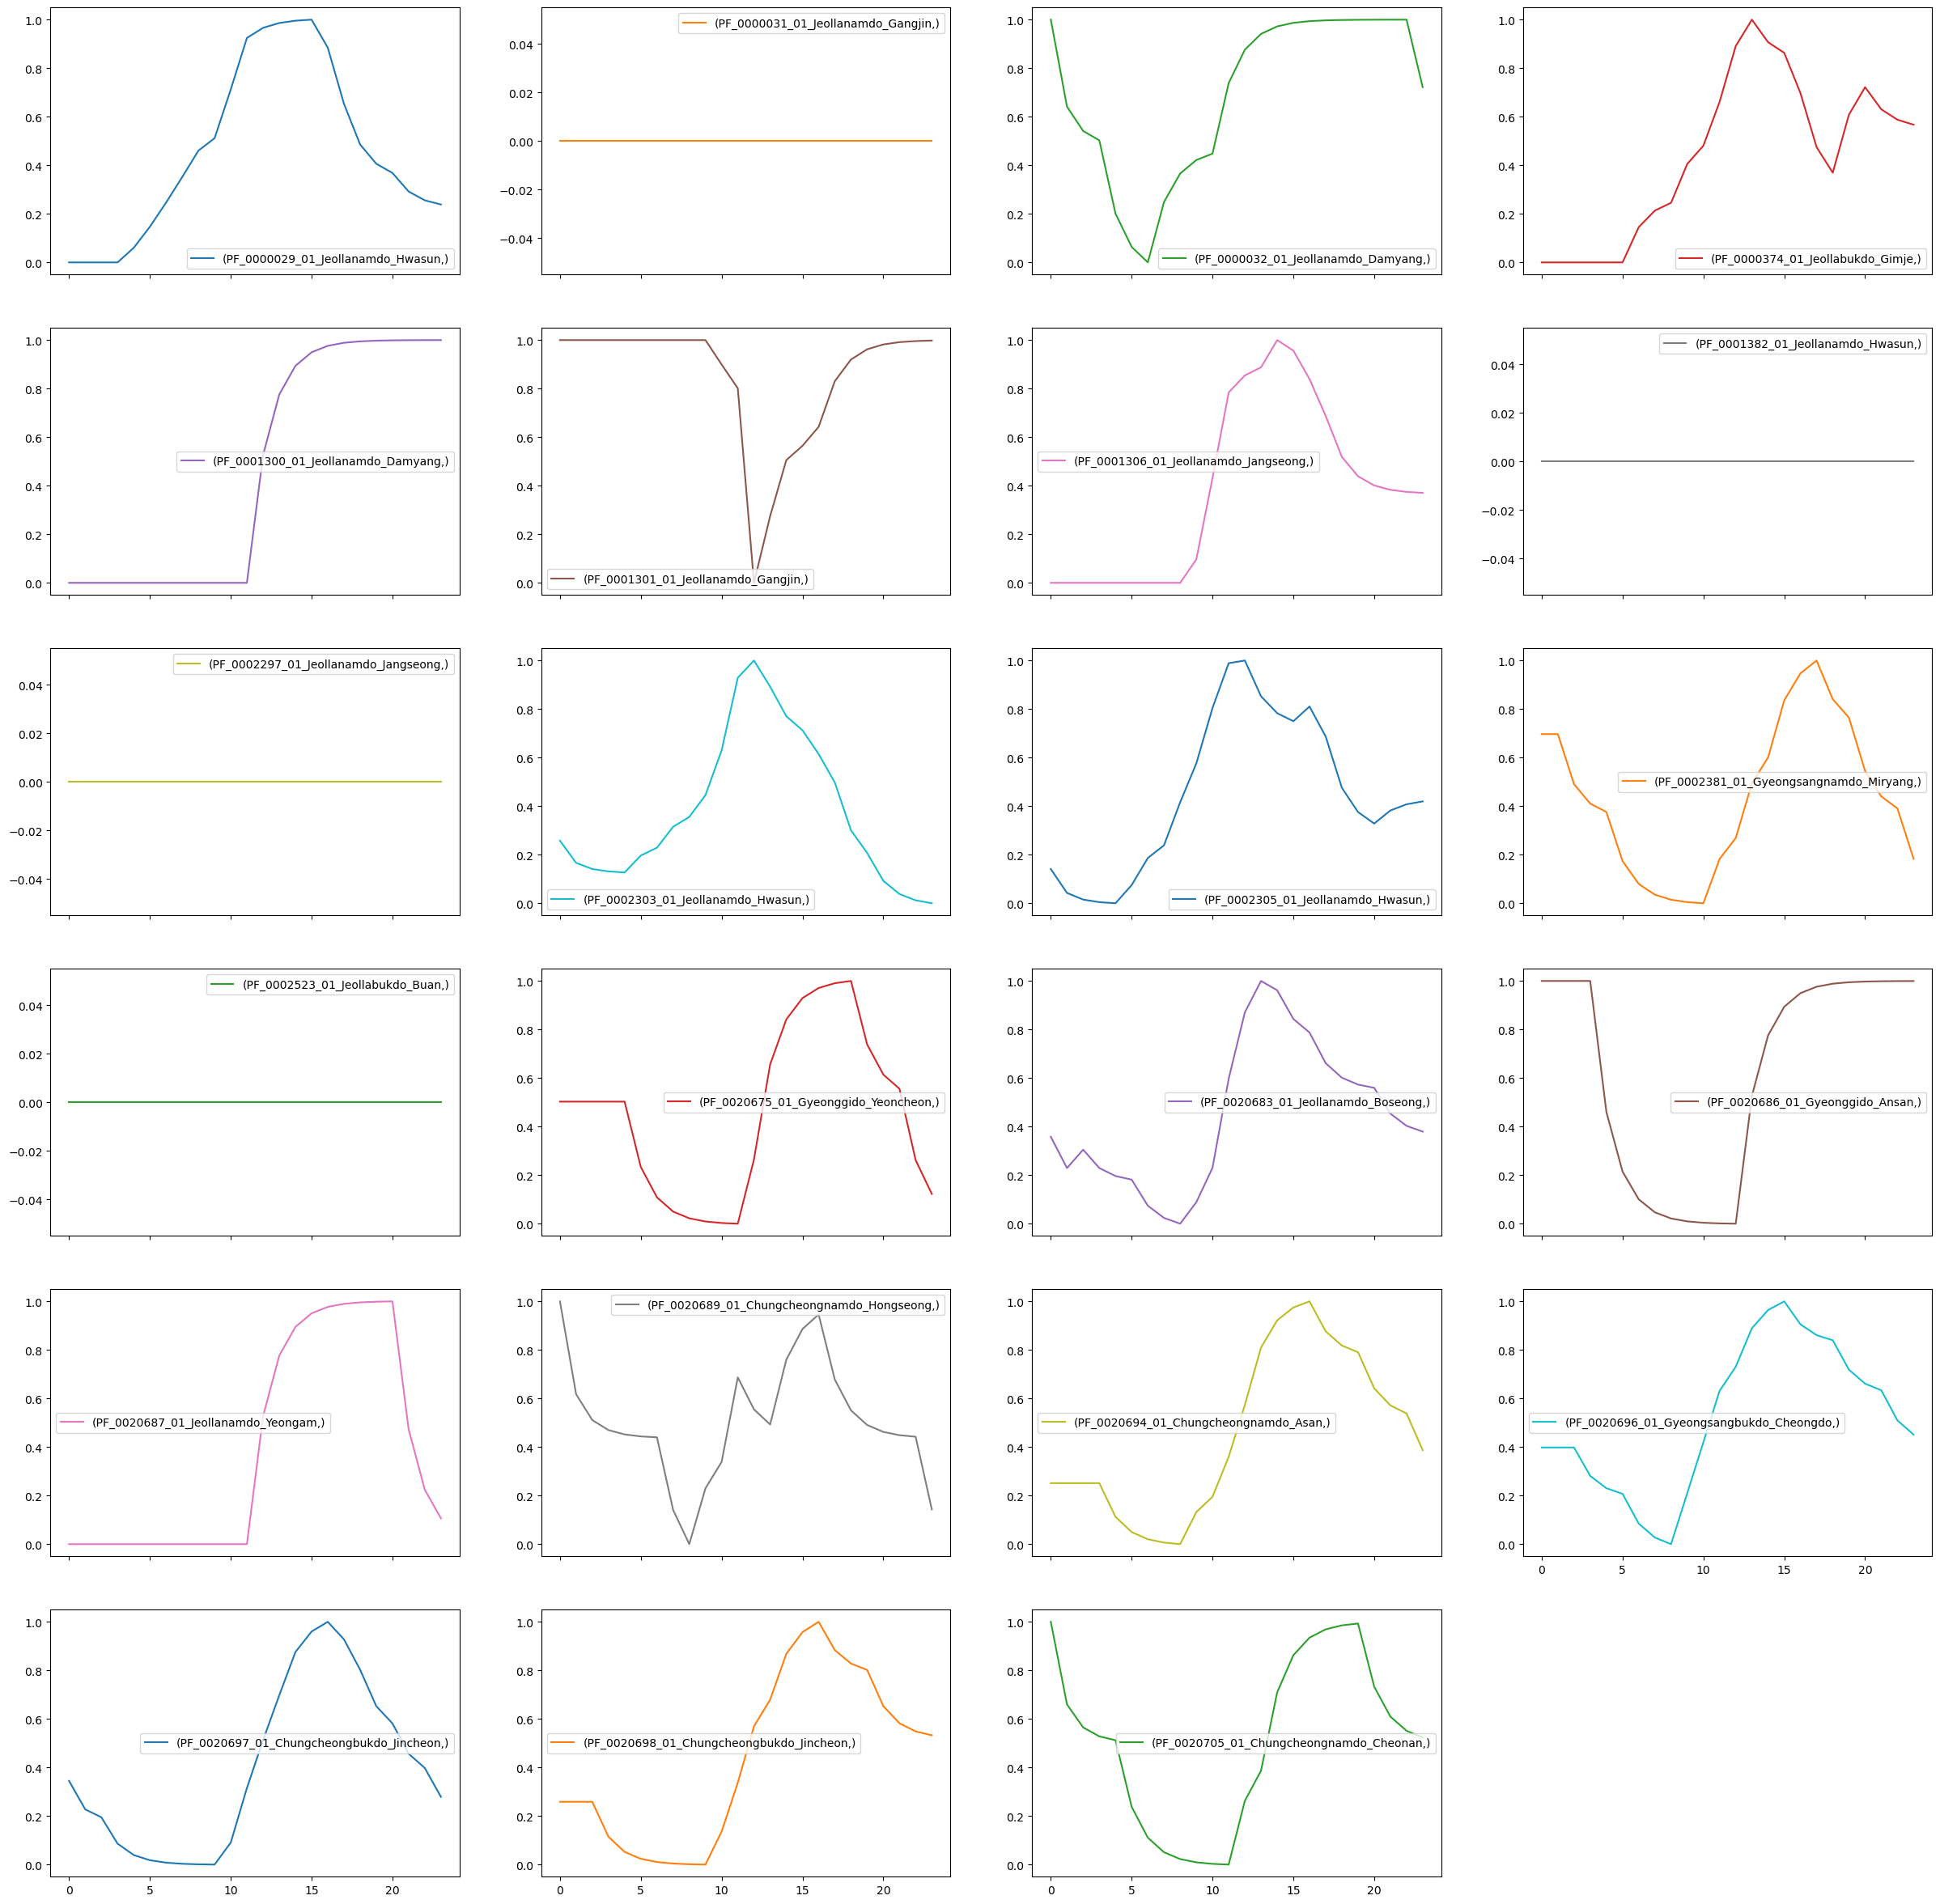

In [8]:
from Clust.clust.tool.plot_graph import plot_features
plot_features.plot_all_column_data_inSubPlot(data, fig_width, fig_height, fig_width_num = 4)

### 5-2. Som Clustering

In [9]:
data_series = data.to_numpy().transpose()
data_name = list(data.columns)
result = somV.train()
figdata, figdata2= somV.make_figs()
plt.show()

NameError: name 'somV' is not defined

In [ ]:
result